# Objective
* Investigate using Weiner filter to predict daily returns of stock

# Assumptions:
* Input signal is WSS (ie. 1. mean and variance is contant, and 2. autocorrelation is dependent only on the time difference) - this helps to ensure autocorrelation matrix is symmetric and toeplitz

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objs as go
import chart_studio.plotly as py

from collections import defaultdict
from pylab import rcParams
from sklearn.metrics import mean_squared_error

%matplotlib inline

#### Input params ######
input_path = "GOOG.csv"
train_end = '2018-02-15'  # training set is all dates <= train_end
cv_start = '2018-02-16'   # cv set is all dates >= cv_start and <= cv_end
cv_end = '2018-05-15'
test_start = '2018-05-16' # test set is all dates >= test_start
Nw = 5                    # length of Weiner filter
Nw_min = 3                # Test Nw param from Nw_min to Nw_max
Nw_max = 11
########################

# Common functions

In [33]:
def comp_autocorr_mat(x, Nw):
    """
    Construct autocorrelation matrix R of size Nw by Nw
    """
    # Compute autocorrelation
    autocorr = np.correlate(x, x, 'full')
    
    # Construct autocorrelation matrix
    ind_max = int((len(autocorr)-1)/2)
    row = autocorr[ind_max:ind_max+Nw]
    R = [row]
    for i in range(1, Nw):
        row = autocorr[ind_max-i:ind_max+Nw-i]
        R.append(row)
    R = np.mat(R)
    return R

def comp_crosscorr_vec(x, d, Nw):
    """
    Construct cross-correlation vector p of size Nw by 1
    """
    # Compute crosscorrelation
    crosscorr = np.correlate(x, d, 'full')
    
    # Construct cross-correlation matrix
    ind_max = int((len(crosscorr)+1)/2)
    row = np.mat(crosscorr[ind_max:ind_max+Nw])
    return row.T

def mape(y_true, y_pred): 
    """
    Mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred): 
    """
    Symmetric mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Load data

In [34]:
df = pd.read_csv("./data/" + input_path)
print("len(df) = " + str(len(df)))
df.head()

len(df) = 251


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-14,922.530029,924.668030,918.190002,922.669983,922.669983,1064500
1,2017-08-15,924.229980,926.549988,919.820007,922.219971,922.219971,883400
2,2017-08-16,925.289978,932.700012,923.445007,926.960022,926.960022,1006700
3,2017-08-17,925.780029,926.859985,910.979980,910.979980,910.979980,1277200
4,2017-08-18,910.309998,915.275024,907.153992,910.669983,910.669983,1342700


# EDA

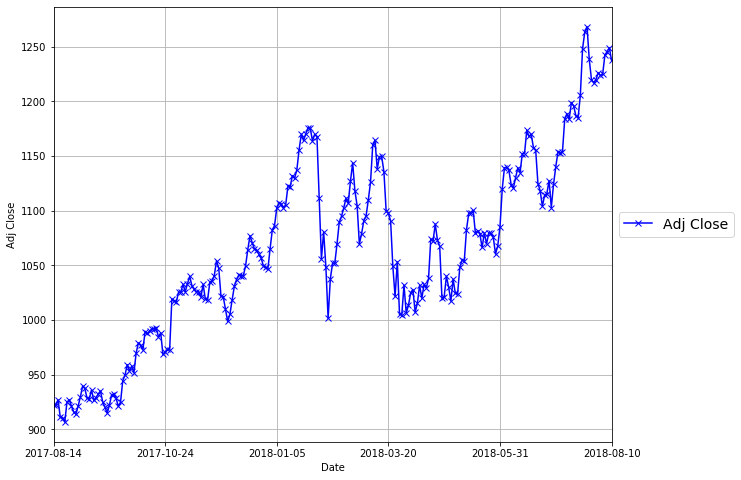

In [35]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='Date', y='Adj Close', style = 'bx-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure


In [36]:
data = [go.Scatter(
            x = df['Date'],
            y = df['Adj Close'],
            name = input_path,
        mode = 'lines+markers'
        )]

layout = dict(title = input_path,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Adj Close'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=input_path)


# Get daily returns and plot

In [37]:
df['daily_return'] = df['Adj Close'].pct_change()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2017-08-14,922.530029,924.668030,918.190002,922.669983,922.669983,1064500,NaN
1,2017-08-15,924.229980,926.549988,919.820007,922.219971,922.219971,883400,-0.000488
2,2017-08-16,925.289978,932.700012,923.445007,926.960022,926.960022,1006700,0.005140
3,2017-08-17,925.780029,926.859985,910.979980,910.979980,910.979980,1277200,-0.017239
4,2017-08-18,910.309998,915.275024,907.153992,910.669983,910.669983,1342700,-0.000340


In [38]:
# Plot line plot
data = [go.Scatter(
            x = df['Date'],
            y = df['daily_return'],
            name = input_path,
        mode = 'lines+markers'
        )]

layout = dict(title = input_path,
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Adj Close'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=input_path)


In [39]:
# Plot histogram
data = [go.Histogram(x=df['daily_return'],
                     histnorm='probability')]

py.iplot(data, filename='normalized histogram')

In [40]:
group_labels = ['normal curve']

fig = ff.create_distplot([np.array(df['daily_return'][1:])], group_labels, curve_type='normal')

# Add title
fig['layout'].update(title='Distplot with Normal Distribution')

# Plot
py.iplot(fig, filename='Distplot with Normal Curve')


# Get desired signal

In [41]:
df['desired_signal'] = df['daily_return'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,desired_signal
0,2017-08-14,922.530029,924.668030,918.190002,922.669983,922.669983,1064500,NaN,-0.000488
1,2017-08-15,924.229980,926.549988,919.820007,922.219971,922.219971,883400,-0.000488,0.005140
2,2017-08-16,925.289978,932.700012,923.445007,926.960022,926.960022,1006700,0.005140,-0.017239
3,2017-08-17,925.780029,926.859985,910.979980,910.979980,910.979980,1277200,-0.017239,-0.000340
4,2017-08-18,910.309998,915.275024,907.153992,910.669983,910.669983,1342700,-0.000340,-0.004403


# Compute autocorrelation matrix

In [42]:
# Compute autocorrelation
autocorr = np.correlate(df['daily_return'][1:], df['daily_return'][1:], 'full')

In [43]:
# Plot autocorrelation
data = [go.Scatter(
            x = np.arange(-(len(autocorr)-1)/2, (len(autocorr)-1)/2),
            y = autocorr,
            mode = 'lines+markers'
        )]

layout = dict(title = 'Autocorrelation',
              xaxis = dict(title = 'Time instant'),
              yaxis = dict(title = 'Autocorrelation'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Autocorrelation')


In [44]:
# Construct autocorrelation matrix
ind_max = int((len(autocorr)-1)/2)
row = autocorr[ind_max:ind_max+Nw]
R = [row]
for i in range(1, Nw):
    row = autocorr[ind_max-i:ind_max+Nw-i]
    R.append(row)
R = np.mat(R)
R

matrix([[ 0.05087488,  0.00380865, -0.0025293 ,  0.0089848 , -0.00076163],
        [ 0.00380865,  0.05087488,  0.00380865, -0.0025293 ,  0.0089848 ],
        [-0.0025293 ,  0.00380865,  0.05087488,  0.00380865, -0.0025293 ],
        [ 0.0089848 , -0.0025293 ,  0.00380865,  0.05087488,  0.00380865],
        [-0.00076163,  0.0089848 , -0.0025293 ,  0.00380865,  0.05087488]])

# Compute cross-correlation matrix

In [45]:
# Compute crosscorrelation
crosscorr = np.correlate(df['daily_return'][1:-1], df['desired_signal'][1:-1], 'full')
crosscorr

array([ 4.48642272e-06, -4.86458261e-05,  1.71646637e-04, -3.80934933e-05,
        6.53130592e-05, -4.36384635e-04, -1.17432862e-05,  1.14068127e-04,
        2.49380927e-04,  5.51935166e-06, -2.77210379e-04,  6.96757800e-05,
        4.15576918e-04,  1.92526850e-04, -4.04339285e-05, -9.41721079e-04,
       -3.63887873e-04,  3.49013168e-04,  9.29768975e-04,  4.72299317e-04,
       -1.04853707e-03, -6.37403916e-04, -1.61295068e-04,  4.98219427e-04,
        4.91131799e-04,  1.88896045e-04,  1.78747653e-04, -2.12248426e-04,
       -7.49635504e-04,  4.92555255e-04, -1.17617019e-04,  9.54453989e-04,
       -2.55863008e-04,  8.84318272e-04, -6.61487962e-04, -2.09680334e-05,
       -6.95971602e-06,  1.07178993e-03, -8.40472986e-05, -1.24749481e-04,
       -9.51037544e-04, -2.01333904e-04, -4.57255802e-04,  1.05742249e-03,
        5.58462544e-04, -2.01162912e-05, -6.66878939e-04, -4.62117517e-04,
        1.04769438e-03,  3.38952170e-04,  9.53122950e-04, -5.38376016e-04,
       -8.31364886e-04,  

In [46]:
# Plot autocorrelation
data = [go.Scatter(
            x = np.arange(-(len(crosscorr)+1)/2, (len(crosscorr)+1)/2),
            y = crosscorr,
            mode = 'lines+markers'
        )]

layout = dict(title = 'Cross-correlation',
              xaxis = dict(title = 'Time instant'),
              yaxis = dict(title = 'Cross-correlation'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Cross-correlation')

In [47]:
# Compute cross-correlation vector
p = comp_crosscorr_vec(df['daily_return'][1:-1], df['desired_signal'][1:-1], Nw)
p

matrix([[ 0.05079003],
        [ 0.00383693],
        [-0.0025126 ],
        [ 0.00911569],
        [-0.00075581]])

# Split into train, cv and test sets

In [48]:
train = df[df['Date'] <= train_end]
cv = df[(df['Date'] >= cv_start) & (df['Date'] <= cv_end)]
test = df[df['Date'] >= test_start]
print("len(df) = " + str(len(df)))
print("len(train) = " + str(len(train)))
print("len(cv) = " + str(len(cv)))
print("len(test) = " + str(len(test)))

len(df) = 251
len(train) = 129
len(cv) = 61
len(test) = 61


In [49]:
train

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,desired_signal
0,2017-08-14,922.530029,924.668030,918.190002,922.669983,922.669983,1064500,NaN,-0.000488
1,2017-08-15,924.229980,926.549988,919.820007,922.219971,922.219971,883400,-0.000488,0.005140
2,2017-08-16,925.289978,932.700012,923.445007,926.960022,926.960022,1006700,0.005140,-0.017239
3,2017-08-17,925.780029,926.859985,910.979980,910.979980,910.979980,1277200,-0.017239,-0.000340
4,2017-08-18,910.309998,915.275024,907.153992,910.669983,910.669983,1342700,-0.000340,-0.004403
5,2017-08-21,910.000000,913.000000,903.400024,906.659973,906.659973,943400,-0.004403,0.019886
6,2017-08-22,912.719971,925.859985,911.474976,924.690002,924.690002,1166700,0.019886,0.002498
7,2017-08-23,921.929993,929.929993,919.359985,927.000000,927.000000,1090200,0.002498,-0.006170
8,2017-08-24,928.659973,930.840027,915.500000,921.280029,921.280029,1270300,-0.006170,-0.005851
9,2017-08-25,923.489990,925.554993,915.500000,915.890015,915.890015,1053400,-0.005851,-0.002271


# Compute Weiner filter and do predictions on CV set

In [50]:
# Compute Weiner filter coefficients
w = R.I*p
w

matrix([[ 9.97712146e-01],
        [ 9.43128508e-04],
        [-1.00833887e-04],
        [ 3.05526649e-03],
        [-3.20138153e-04]])

In [51]:
# Compute prediction column
pred = [float('nan')]*(Nw-1)
for i in range(Nw, len(cv)+1):
    x = np.mat(cv.iloc[i-Nw:i]['daily_return'])
    pred.append((x*w).item(0))
    
cv['predictions'] = pred
cv

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,desired_signal,predictions
129,2018-02-16,1088.410034,1104.670044,1088.312988,1094.800049,1094.800049,1681600,0.004846,0.006997,NaN
130,2018-02-20,1090.569946,1113.949951,1088.520020,1102.459961,1102.459961,1423100,0.006997,0.008055,NaN
131,2018-02-21,1106.469971,1133.969971,1106.329956,1111.339966,1111.339966,1512900,0.008055,-0.004238,NaN
132,2018-02-22,1116.189941,1122.819946,1102.589966,1106.630005,1106.630005,1317200,-0.004238,0.018218,NaN
133,2018-02-23,1112.640015,1127.280029,1104.713989,1126.790039,1126.790039,1261000,0.018218,0.015052,0.004822
134,2018-02-26,1127.800049,1143.959961,1126.694946,1143.750000,1143.750000,1559100,0.015052,-0.022260,0.007039
135,2018-02-27,1141.239990,1144.040039,1118.000000,1118.290039,1118.290039,1774100,-0.022260,-0.012126,0.008084
136,2018-02-28,1123.030029,1127.530029,1103.239990,1104.729980,1104.729980,1882600,-0.012126,-0.031872,-0.004277
137,2018-03-01,1107.869995,1110.119995,1067.000977,1069.520020,1069.520020,2515900,-0.031872,0.008789,0.018165
138,2018-03-02,1053.079956,1081.999023,1048.114990,1078.920044,1078.920044,2271600,0.008789,0.011132,0.014897


In [52]:
# Compute RMSE
mean_squared_error(cv['desired_signal'][Nw:], cv['predictions'][Nw:])

0.0008524879553130915

# Compute RMSE on CV set, looping range of values for Nw

In [53]:
# d = {'Nw':[], 'rmse':[], 'mape':[]}
d = defaultdict(list)
for i in range(5, Nw_max+1):
    R = comp_autocorr_mat(train['daily_return'][1:], i)
    p = comp_crosscorr_vec(train['daily_return'][1:-1], train['desired_signal'][1:-1], i)
    w = R.I*p  # Weiner filter coefficients
#     print('R = ' + str(R))
#     print('p = ' + str(p))
#     print(w)
    
    # Compute prediction column
    pred = [float('nan')]*(i-1)
    for j in range(i, len(cv)+1):
        x = np.mat(cv.iloc[j-i:j]['daily_return'])
        pred.append((x*w).item(0))
    
    cv['predictions'] = pred
    d['Nw'].append(i)
    d['rmse'].append(mean_squared_error(cv['desired_signal'][i:], cv['predictions'][i:]))
    d['mape'].append(mape(cv['desired_signal'][i:], cv['predictions'][i:]))
    d['smape'].append(smape(cv['desired_signal'][i:], cv['predictions'][i:]))
    

results_df = pd.DataFrame(d)
results_df

,Nw,rmse,mape,smape
0,5,0.000841,690.358944,76.121224
1,6,0.000704,624.947955,79.443316
2,7,0.000672,541.572155,74.390269
3,8,0.000812,601.272007,76.237559
4,9,0.000727,582.342891,79.037382
5,10,0.000636,1226.127729,78.299484
6,11,0.000868,691.146054,79.355234


In [54]:
# Plot rmse results
data = [go.Scatter(
            x = results_df['Nw'],
            y = results_df['rmse'],
            mode = 'lines+markers'
        )]

layout = dict(title = 'RMSE results',
              xaxis = dict(title = 'Nw'),
              yaxis = dict(title = 'RMSE'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='rmse results')

In [55]:
# Plot mape results
data = [go.Scatter(
            x = results_df['Nw'],
            y = results_df['mape'],
            mode = 'lines+markers'
        )]

layout = dict(title = 'MAPE results',
              xaxis = dict(title = 'Nw'),
              yaxis = dict(title = 'MAPE'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='mape results')

In [56]:
# Plot smape results
data = [go.Scatter(
            x = results_df['Nw'],
            y = results_df['smape'],
            mode = 'lines+markers'
        )]

layout = dict(title = 'SMAPE results',
              xaxis = dict(title = 'Nw'),
              yaxis = dict(title = 'SMAPE'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='smape results')